In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
n = 9
p = 11
m = 2
epsi = 0.00000001
X = np.array([[3.033333, 4.966667, 2.666667, 4.9, 3.433333, 4.8, 4.366667, 5.833333, 3.533333], 
             [5.766667, 3.7, 5.533333, 2.7, 4.7, 3.133333, 4.833333, 2.4, 5.033333], 
             [5.233333, 2.5, 5.366667, 3.833333, 5.966667, 4.333333, 4.733333, 2.466667, 4.1], 
             [5.066667, 5.133333, 4.466667, 5.966667, 3.8, 6.5, 6.233333, 5.6, 3.266667], 
             [3.366667, 5.233333, 2.7, 3.133333, 3.066667, 3.8, 3.2, 5.4, 3.6], 
             [6.033333, 4.166667, 5.633333, 3.033333, 4.5, 3.066667, 4.633333, 2.533333, 4.5], 
             [5.1, 5.766667, 4.3, 2.366667, 2.566667, 2.1, 4.166667, 4.133333, 4.5], 
             [3.566667, 4.833333, 3.266667, 4.933333, 3.766667, 5.133333, 4.466667, 5.3, 3.133333], 
             [2.966667, 5.666667, 2.266667, 4.066667, 3, 4.733333, 3.133333, 5.766667, 3.533333], 
             [4.9, 5.033333, 4.4, 2.833333, 3.466667, 3.566667, 4.733333, 4.333333, 3.866667], 
             [2.166667, 6.133333, 2.2, 1.9, 1.533333, 2.166667, 2.833333, 5.133333, 3.9]])
X = X.T
# objective function eta
def eta(R):
    Rrev = (n ** (1/2)) * R @ np.linalg.inv(scipy.linalg.sqrtm(R.T @ R))
    return np.sum((X - np.ones((n, 1)) @ np.array([c])) * distance.cdist(Rrev, A, metric = 'euclidean'))
# numerical differentiation
omic = 0.001
def grad(R):
    G = np.empty((n, m))
    for i in range(n):
        for k in range(m):
            H = np.zeros((n, m))
            H[i, k] = 1
            G[i, k] = (eta(R + omic * H) - eta(R - omic * H)) / (2 * omic)
    return G
# objective function of A
def obja(A):
    return n * np.trace(A.T @ A) - 2 * np.sum((np.ones((n, 1)) @ np.array([c]) - X) * distance.cdist(F, A, metric = 'euclidean'))

In [2]:
# principal component analysis (initialize F, A)
J = np.eye(n) - (n ** -1 * np.ones((n, n)))
K, lambda_vec, L_trans = np.linalg.svd(J @ X, full_matrices = False)
Km = K[:, :m]
Lambdam = np.diag(lambda_vec)[:m, :m]
L = L_trans.T
Lm = L[:, :m]
Fpca = (n ** (1/2)) * Km
Apca = (n ** (-1/2)) * Lm @ Lambdam
# objective function of PCA
cpca = np.mean(X, axis = 0)
np.linalg.norm((X - np.ones((n, 1)) @ np.array([cpca]) - Fpca @ Apca.T), 2) ** 2

8.563485691632305

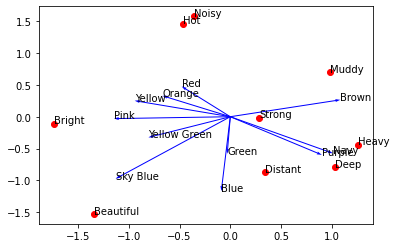

In [3]:
x1, y1 = zip(*Fpca)
x2, y2 = zip(*Apca)
nlist = ['Deep', 'Beautiful', 'Heavy', 'Noisy', 'Muddy', 'Hot', 'Strong', 'Bright', 'Distant']
plist = ['Yellow', 'Navy', 'Brown', 'Red', 'Yellow Green', 'Purple', 'Blue', 'Orange', 'Pink', 'Green', 'Sky Blue']
for i, label in enumerate(nlist):
    plt.annotate(label, (x1[i], y1[i]))
for i, label in enumerate(plist):
    plt.annotate(label, (x2[i], y2[i]))

plt.scatter(x1, y1, marker = 'o', color = 'r', label = 'attributes')

for i in range(p):
    plt.quiver(0, 0, x2[i], y2[i], color = "blue",
          angles = 'xy', scale_units = 'xy', scale = 1, width=0.003)

plt.show()

In [4]:
# algorithm of the estimation of MDU approach

# initialize F, A
Rinit = np.random.normal(0, 1, (n, m))
Rnew = J @ Rinit
F = (n ** (1/2)) * Rnew @ np.linalg.inv(scipy.linalg.sqrtm(Rnew.T @ Rnew))
A = np.random.normal(0, 1, (p, m))
Za = np.random.normal(0, 1, (p, m))
c = np.mean(X, axis = 0) + np.mean(distance.cdist(F, A, metric = 'euclidean'), axis = 0)
# initial value of objective function
path = {}
path[1] = [F, A, c]
stressall_new = np.linalg.norm((X - (np.ones((n, 1)) @ np.array([c]) - distance.cdist(F, A, metric = 'euclidean'))), 2) ** 2
stressall_box = []
stressall_box.append(stressall_new)
k = 1

# iteration algorithm
while True:
    stressall_old = stressall_new

    # update of F (gradient projection algorithm revised)
    while True: 
        Rold = Rnew
        step = 1
        G = grad(Rold)
        if eta(Rold) > eta(J @ (Rold - step * G)):            
            alpha = step
        else:
            while eta(J @ (Rold - step * G)) >= eta(Rold):
                step /= 2
            alpha = step
        Rnew = J @ (Rold - alpha * G)
        if eta(Rold) - eta(Rnew) < 0.00001:
            break
    R = Rnew
    F = (n ** (1/2)) * R @ np.linalg.inv(scipy.linalg.sqrtm(R.T @ R))
    
    # update of A (Generalized majorization)
    Q = np.ones((n, 1)) @ np.array([c]) - X
    stressa_box = []
    stressa_new = obja(A)
    stressa_box.append(stressa_new)
    if k > 1:
        Za = A
    while True:
        stressa_old = stressa_new
        Dz = distance.cdist(F, Za, metric = 'euclidean')
        Delta = np.where((Q < 0) & (Dz > 0), np.abs(Q) / Dz, 0) + np.where((Q < 0) & (Dz == 0), (Q ** 2) / epsi, 0)
        Phi = np.where((Q >= 0) & (Dz > 0), Q / Dz, 0)
        Deltadiag = np.diag(np.sum(Delta, axis = 0))
        Phidiag = np.diag(np.sum(Phi, axis = 0))
        V = Delta - Phi
        A = np.linalg.inv(n * np.eye(p) + Deltadiag) @ (Phidiag @ Za + V.T @ F)
        stressa_new = obja(A)
        stressa_box.append(stressa_new)
        if stressa_old - stressa_new < 0.0001:
            break
        else:
            Za = A
    
    # optimization of c
    c = np.mean(X, axis = 0) + np.mean(distance.cdist(F, A, metric = 'euclidean'), axis = 0)
    
    k += 1
    path[k] = [F, A, c]
    stressall_new = np.linalg.norm((X - (np.ones((n, 1)) @ np.array([c]) - distance.cdist(F, A, metric = 'euclidean'))), 2) ** 2
    stressall_box.append(stressall_new)
    if stressall_old - stressall_new < 0.0001:
        break

print(stressall_new)

6.232565345844679


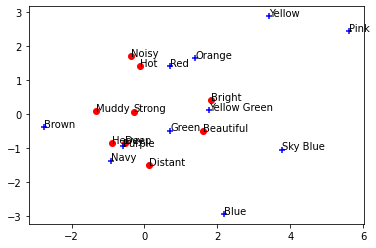

In [9]:
x1, y1 = zip(*F)
x2, y2 = zip(*A)
nlist = ['Deep', 'Beautiful', 'Heavy', 'Noisy', 'Muddy', 'Hot', 'Strong', 'Bright', 'Distant']
plist = ['Yellow', 'Navy', 'Brown', 'Red', 'Yellow Green', 'Purple', 'Blue', 'Orange', 'Pink', 'Green', 'Sky Blue']
for i, label in enumerate(nlist):
    plt.annotate(label, (x1[i], y1[i]))
for i, label in enumerate(plist):
    plt.annotate(label, (x2[i], y2[i]))
plt.scatter(x1, y1, marker = 'o', color = 'r', label = 'attributes')
plt.scatter(x2, y2, marker = '+', color = 'b', label = 'color')
plt.show()

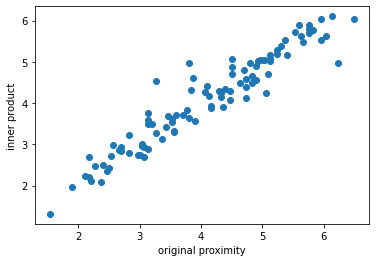

In [7]:
x = np.ravel(X)
y = np.ravel(np.ones((n, 1)) @ np.array([cpca]) + Fpca @ Apca.T)
plt.scatter(x, y)
plt.xlabel('original proximity')
plt.ylabel('inner product')
plt.show()

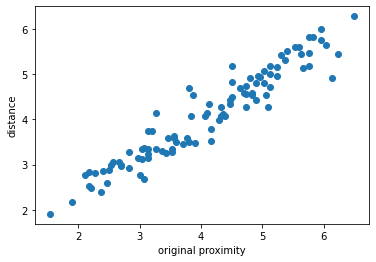

In [8]:
x = np.ravel(X)
y = np.ravel(np.ones((n, 1)) @ np.array([c]) - distance.cdist(F, A, metric = 'euclidean'))
plt.scatter(x, y)
plt.xlabel('original proximity')
plt.ylabel('distance')
plt.show()